# Microsimulation with artificial survey data 

In [33]:
import matplotlib.pyplot as plt  # For graphics
%matplotlib inline

import numpy as np  # linear algebra and math
import pandas as pd  # data frames

from openfisca_core.model_api import *
from openfisca_senegal import SenegalTaxBenefitSystem  # The Senegalese tax-benefits system

from openfisca_senegal.survey_scenarios import SenegalSurveyScenario

## Building the artificial data

Sénégal is composed by almost 15 millions people dispatched in around 1.6 million household

In [34]:
household_weight = 100
size = int(1.6e6 / household_weight)
print "Size of the sample: {}".format(size)
np.random.seed(seed = 42)

Size of the sample: 16000


We assume that 2/3 of the household heads are married and that only married houshold do have children. The mean number of children per household is 5 and is normally distributed

In [35]:
est_marie = np.random.binomial(1, .66, size = size)
est_celibataire = np.logical_not(est_marie)
nombre_enfants = np.maximum(
    est_marie * np.round(np.random.normal(5, scale = 3, size = size)),
    0,
    )

We assume that 80% of the population are wage earners.
We choose a mean wage of 5 000 0000 CFA with a log normal ditribution.
Since 
$$ \text{mean wage}  = e^{\mu + \frac{\sigma ^ 2}{2}} $$ 
and
$$ \text{median wage} = e^\mu $$
we can compute the distribution according to the following expressions.

In [36]:
mean_wage = 5e6
median_wage = .75 * mean_wage
est_salarie = np.random.binomial(1, .8, size = size)
mu = np.log(median_wage)
sigma = np.sqrt(2 * np.log(mean_wage / median_wage))
salaire = (
    est_salarie * 
    np.random.lognormal(mean = mu, sigma = sigma, size = int(size))
    )


We choose a mean pension of 2 500 000 CFA

In [37]:
mean_pension = 2.5e6
median_pension = .9 * mean_pension

In [38]:
mu = np.log(median_pension)
sigma = np.sqrt(2 * np.log(mean_pension / median_pension))
pension_retraite = (
    np.logical_not(est_salarie) *
    np.random.lognormal(mean = mu, sigma = sigma, size = int(size))
    )

In [40]:
input_data_frame = pd.DataFrame({
    'est_marie': est_marie,
    'est_celibataire': est_celibataire,
    'nombre_enfants': nombre_enfants,
    'pension_retraite': pension_retraite,
    'salaire': salaire,
    'id_famille': range(size),
    'role_famille': 0,
    })

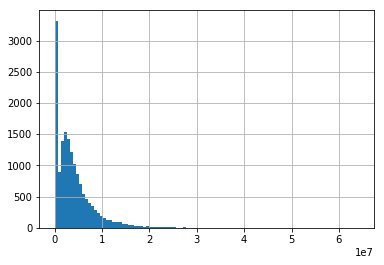

In [41]:
input_data_frame.salaire.hist(bins=100)

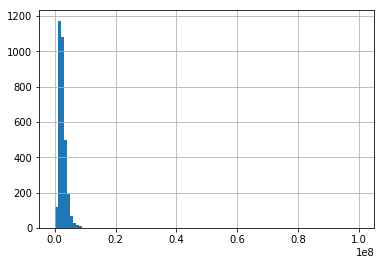

In [9]:
input_data_frame.pension_retraite.hist(bins=100, range = [.0001, 1e8])

## Microsimulation 

As with test case, we can build a scenario with survey data

In [42]:
scenario = SenegalSurveyScenario(
    input_data_frame=input_data_frame, year = 2017
    )

We can compute the value of any variable for the whole population an draw distributions

In [43]:
scenario.simulation.calculate('impot_revenus', period = 2017)

array([     0., 221100., 974400., ..., 233100., 933800., 309600.],
      dtype=float32)

In [44]:
df = pd.DataFrame({'impot_revenus': scenario.simulation.calculate('impot_revenus', period = 2017)})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd97ccf8ad0>]],
      dtype=object)

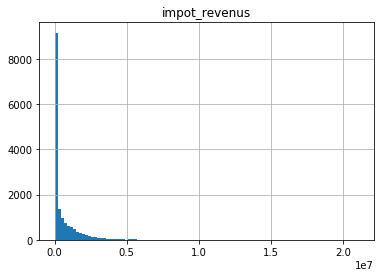

In [45]:
df.hist(bins = 100)

Special methods allow access to aggregates and pivot tables

In [46]:
scenario.compute_aggregate('impot_revenus') / 1e9

9.67353344

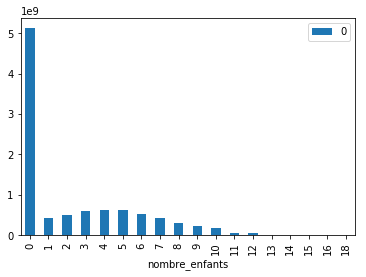

In [47]:
scenario.compute_pivot_table(
    aggfunc = 'sum', 
    values = ['impot_revenus'], 
    columns = ['nombre_enfants'],
    period = 2017,
    ).stack().reset_index().plot(x = 'nombre_enfants', kind = 'bar')

# Evaluate the financial impact of a reform

Write a parametric reform tthat increseases the top marginal tax rates and evaluate how much revenue can be collected

In [48]:
year = 2017
def modify_parameters(parameters):
    parameters.bareme_impot_progressif[5].rate.update(period = period(year), value = .5)
    return parameters
    
class tax_the_rich(Reform):
    name = u"Tax last bracket at 50%"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [17]:
senegal_tax_benefit_system = SenegalTaxBenefitSystem()
tax_the_rich_tax_benefit_system = tax_the_rich(senegal_tax_benefit_system)

In [49]:
scenario = SenegalSurveyScenario(
    input_data_frame = input_data_frame,
    tax_benefit_system = tax_the_rich_tax_benefit_system,
    baseline_tax_benefit_system = senegal_tax_benefit_system,
    year = 2017,
    )

In [50]:
print 'reform tax the rich: ', scenario.compute_aggregate('impot_revenus') / 1e9
print 'baseline: ', scenario.compute_aggregate('impot_revenus', use_baseline = True) / 1e9

reform tax the rich:  9.931257856
baseline:  9.67353344


In [51]:
from openfisca_senegal.entities import Person

def build_ultimate_reform_tax_benefit_system(seuil = 0, marginal_tax_rate = .4):
    year = 2017

    senegal_tax_benefit_system = SenegalTaxBenefitSystem()
    class impot_revenus(Variable):
        def formula(individu, period):
            impot_avant_reduction_famille = individu('impot_avant_reduction_famille', period)
            reduction_impots_pour_charge_famille = individu('reduction_impots_pour_charge_famille', period)
            impot_apres_reduction_famille = impot_avant_reduction_famille - reduction_impots_pour_charge_famille
            impot_revenus = max_(0, impot_apres_reduction_famille)
            return impot_revenus * (impot_revenus > seuil)            

    def modify_parameters(parameters):
        parameters.bareme_impot_progressif[5].rate.update(period = period(year), value = marginal_tax_rate)
        return parameters


    class ultimate_reform(Reform):
        name = u"Tax the rich and save the poor taxpayers (tax < {})".format(seuil)

        def apply(self):
            self.update_variable(impot_revenus)
            self.modify_parameters(modifier_function = modify_parameters)

    return ultimate_reform(senegal_tax_benefit_system)

In [52]:
reformed_tax_benefit_system = build_ultimate_reform_tax_benefit_system(seuil = 100000, marginal_tax_rate = .45)

In [53]:
scenario = SenegalSurveyScenario(
    input_data_frame = input_data_frame,
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = SenegalTaxBenefitSystem(),
    year = 2017
    )

In [54]:
print 'reform: ', scenario.compute_aggregate('impot_revenus') / 1e9
print 'baseline: ', scenario.compute_aggregate('impot_revenus', use_baseline = True) / 1e9

reform:  9.753219072
baseline:  9.67353344


In [55]:
scenario = SenegalSurveyScenario(
    input_data_frame = input_data_frame,
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system =  SenegalTaxBenefitSystem(),
    year = 2017
    )
print scenario.compute_aggregate('impot_revenus') / 1e9
print scenario.compute_aggregate('impot_revenus', use_baseline = True) / 1e9
cost = - (
    scenario.compute_aggregate('impot_revenus') -
    scenario.compute_aggregate('impot_revenus', use_baseline = True)
    ) / 1e9
print cost

9.753219072
9.67353344
-0.079685632


In [56]:
def compute_reform_cost(seuil):
    reformed_tax_benefit_system = build_ultimate_reform_tax_benefit_system(
        seuil = seuil, 
        marginal_tax_rate = .41
        )
    scenario = SenegalSurveyScenario(
        input_data_frame = input_data_frame,
        tax_benefit_system = reformed_tax_benefit_system,
        baseline_tax_benefit_system = SenegalTaxBenefitSystem(),
        year = 2017
        )
    cost = - (
        scenario.compute_aggregate('impot_revenus') - 
        scenario.compute_aggregate('impot_revenus', use_baseline = True)
        ) / 1e9
    return cost

In [57]:
compute_reform_cost(seuil = 100000)

0.023097344

In [58]:
from scipy.optimize import fsolve
x = fsolve(compute_reform_cost, 100000)
x

array([71635.74048561])

In [28]:
compute_reform_cost(seuil = x)

3.4816e-05

In [59]:
reformed_tax_benefit_system = build_ultimate_reform_tax_benefit_system(
        seuil = x, 
        marginal_tax_rate = .41
        )
scenario = SenegalSurveyScenario(
    input_data_frame = input_data_frame,
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = SenegalTaxBenefitSystem(),
    year = 2017
    )

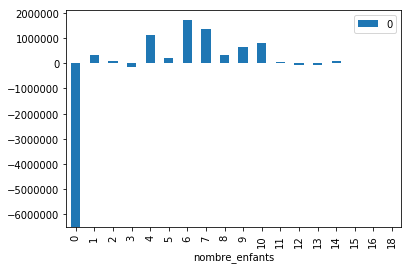

In [60]:
scenario.compute_pivot_table(
    aggfunc = 'sum', 
    values = ['impot_revenus'], 
    columns = ['nombre_enfants'],
    period = 2017,
    difference = True,
    ).stack().reset_index().plot(x = 'nombre_enfants', kind = 'bar')